<a href="https://colab.research.google.com/github/IandRover/Binary-Addition-with-Liquid-State-Machine/blob/master/Keras_addition_Simuladdition_RNN_%2B_DimReduction_MapVisualization_C10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference

In [ ]:
"""Reference: https://keras.io/examples/addition_rnn/"""

'Reference: https://keras.io/examples/addition_rnn/'

## Import basic packages

In [ ]:
from __future__ import print_function
from keras.callbacks import Callback, TensorBoard
from keras.models import Sequential
from keras import layers
%load_ext tensorboard

from google.colab import files

import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns;

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset Preparation

In [ ]:
#@title Define encode-decoder
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def encode_simul(self, C, num_rows):
        """Simultaneous one-hot encodes the augend given C = [str1, str2].
        # Arguments
            C: list, contains 2 strings, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        # first 11 places for augend, including " "
        # last 11 places for addend, including " "
        x = np.zeros((num_rows, len(self.chars*2)))
        [a,b] = C
        for i in range(DIGITS):
            x[i, self.char_indices[a[i]]] = 1
            x[i, self.char_indices[b[i]]+len(self.chars)] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [ ]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [ ]:
#@title Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = ' 0123456789'
ctable = CharacterTable(chars)

In [ ]:
#@title Produce raw data
questions = []
questions_ = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans = ans[::-1] + ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    augend = " " * (DIGITS-len(str(a))) + str(a)
    addend = " " * (DIGITS-len(str(b))) + str(b)
    questions_.append([augend[::-1], addend[::-1]])
    expected.append(ans)
print('Total addition questions:', len(questions))
print(questions_[0], expected[0], questions_[1], expected[1])

Generating data...
Total addition questions: 50000
['247', '0  '] 247  ['45 ', '8  '] 26  


In [ ]:
#@title Vectorization
x = np.zeros((len(questions), DIGITS + 1, len(chars*2)), dtype=np.bool)
#y = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions_):
    x[i] = ctable.encode_simul(sentence, DIGITS + 1)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
SimpleRNN = layers.SimpleRNN
HIDDEN_SIZE = 15
    ## H100 converges at epoch 12, 
    ## H50 converges at epoch 20
    ## H30 converges at epoch 36
    ## H20 converges at 44
    ## H15 converges at 87
    ## H12 converges at 132
    ## H12 converges at 132
    ## H12 converges at 350
    ## H11 plateau at 150, ACC 0.9989
    ## H10 plateau at 188, ACC 0.9941
BATCH_SIZE = 128
LAYERS = 1

Training Data:
(45000, 4, 22)
(45000, 4, 11)
Validation Data:
(5000, 4, 22)
(5000, 4, 11)


## Build model

In [ ]:
def BuildModel():
    model = Sequential()
    model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(DIGITS + 1, len(chars*2)), return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Source

In [ ]:
model = Sequential()
"""測試一"""
model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(DIGITS + 1, len(chars*2)), return_sequences=True))
"""原始碼+新的格式""" """經過5個epoch即達到100%"""
#model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(DIGITS + 1, len(chars*2))))
#model.add(layers.RepeatVector(DIGITS + 1))
#for _ in range(LAYERS):
#    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
"""原始碼"""
#model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
#model.add(layers.RepeatVector(DIGITS + 1))
#for _ in range(LAYERS):
#    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()
epoch=0

## Training Phase

In [ ]:
#@title Fitting data
print("Setting: " + colors.fail + "HIDDEN SIZE={}".format(HIDDEN_SIZE) + colors.close)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=30,
                    validation_data=(x_val, y_val),
                    callbacks=[tensorboard_callback],
                    verbose=0)

Setting: HIDDEN SIZE=15


###  Accuracy and Loss

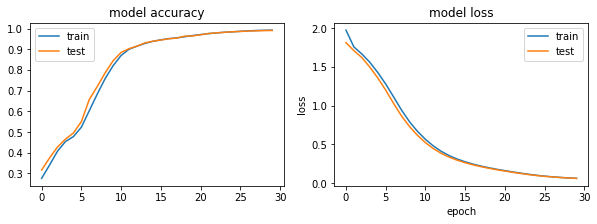

In [ ]:

fig, ax = plt.subplots(ncols=2, figsize=(10,3))
ax[0].plot(history.history['accuracy'],)
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
ax[0].legend(['train', 'test'])
ax[1].plot(history.history['loss']), plt.plot(history.history['val_loss'])
ax[1].set_title('model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
ax[1].legend(['train', 'test'])

### Show examples

In [ ]:
for i in range(5):
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)

    x = np.nonzero(rowx[0])[1]
    y = np.nonzero(rowy[0])[1]
    p = preds[0]
    augend = "".join(chars[x[i]] for i in [4,2,0])
    addend = "".join(chars[x[i]-11] for i in [5,3,1])
    target = "".join(chars[y[i]] for i in range(4))[::-1]
    while p[-1] == 0: p=p[:-1]
    output = "".join(str(p[i]-1) for i in range(len(p)))[::-1]

    print('Q {} + {}'.format(augend, addend), end=' ')
    print('T {}'.format(target), end=' ')

    while target[0] == " ": target=target[1:]
    while target[-1] == " ": target=target[:-1]
    if target == output:
        print(colors.ok + '☑' + colors.close, end=' ')
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(output)

NameError: ignored

## Save model

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#!ls "/content/gdrive/My Drive/Colab Notebooks/202006 BinaryAddition/Model"
#model.save("10D-H3000-RNN.h5")

## Tensorboard

In [ ]:
#%tensorboard --logdir logs

## Check weight

In [ ]:
def GetParams():
    for layer in model.layers:
        weight = layer.get_weights()
        if "rnn" in layer.name:            
            wi = weight[0]
            wh = weight[1]
            wb = weight[2]
        if "time_" in layer.name:
            ri = weight[0]
            ro = weight[1]
    return wi, wh, wb, ri, ro


In [ ]:
for layer in model.layers:
    # get rnn only
    print(len(layer.weights))
    if "rnn" in layer.name:
        print("weight of RNN")
        weight = layer.get_weights()
        wi = weight[0]
        wh = weight[1]
        wb = weight[2]
        print(wi.shape, wh.shape, wb.shape, )

    if "time_" in layer.name:
        print("weight of Dense")
        weight = layer.get_weights()
        ri = weight[0]
        ro = weight[1]
        print(ri.shape, ro.shape)

3
weight of RNN
(22, 15) (15, 15) (15,)
2
weight of Dense
(15, 11) (11,)


#### Check Computation equivalence

In [ ]:
x_test = np.array(x_train[:10])
y_test = np.array(y_train[:10])
print("shape of x: {}".format(x_test.shape))

shape of x: (10, 4, 22)


In [ ]:
def show_():
    for i in range(5):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_train[np.array([ind])], y_train[np.array([ind])]
        preds = AsRNN(rowx)
        preds2 = model.predict_classes(rowx, verbose=0)

        x = np.nonzero(rowx[0])[1]
        y = np.nonzero(rowy[0])[1]
        p = preds[0]
        augend = "".join(chars[x[i]] for i in [4,2,0])
        addend = "".join(chars[x[i]-11] for i in [5,3,1])
        target = "".join(chars[y[i]] for i in range(4))[::-1]
        while p[-1] == 0: p=p[:-1]
        output = "".join(str(p[i]-1) for i in range(len(p)))[::-1]

        print('Q {} + {}'.format(augend, addend), end=' ')
        print('T {}'.format(target), end=' ')

        while target[0] == " ": target=target[1:]

        while target[-1] == " ": target=target[:-1]
        if target == output:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(output)

In [ ]:
def AsRNN(x_test):
    def to_prediction(output):
        prediction = np.dot(output, ri) + ro
        prediction = np.exp(prediction)/sum(np.exp(prediction))
        return np.argmax(prediction)
    Collect_pred = list()
    for batch in x_test:
        prev_output = np.zeros((HIDDEN_SIZE))
        for input in batch:
            h = np.dot(input, wi) + wb  
            output = np.tanh( h + np.dot(prev_output, wh))
            prev_output = output
            Collect_pred.append(to_prediction(output))
    return np.array([Collect_pred])
show_()

Q   5 +  83 T   88 ☑ 88
Q 794 + 703 T 1497 ☑ 1497
Q  61 +  78 T  139 ☑ 139
Q  65 +  71 T  136 ☑ 136
Q   5 + 310 T  315 ☑ 315


(-1.5, 1.5)

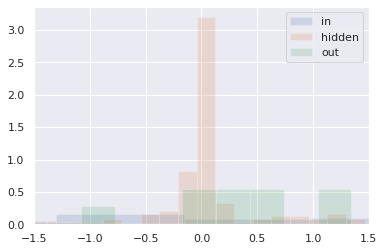

In [ ]:
_ = plt.hist(wi.flatten(), density=True, bins=20, alpha=0.2, label="in")
_ = plt.hist(wh.flatten(), density=True, bins=50, alpha=0.2, label="hidden")
_ = plt.hist(wb.flatten(), density=True, bins=20, alpha=0.2, label="out")
plt.legend()
plt.xlim([-1.5,1.5])

## Model Inspection

In [ ]:
#@ check the inter
import heapq
    
ind = np.random.randint(0, len(x_val))
rowx, rowy = x_train[np.array([ind])], y_train[np.array([ind])]

x_test = rowx
def to_prediction(output, num):
    prediction = np.dot(output, ri) + ro
    prediction = np.exp(prediction)/sum(np.exp(prediction))
    return prediction.argsort()[-num:][::-1] - 1
Collect_Before = list()
Collect_After = list()
for batch in x_test:
    prev_output = np.zeros((HIDDEN_SIZE))
    for input in batch:
        h = np.dot(input, wi) + wb  
        Collect_Before.append(to_prediction(h, 3))
        output = np.tanh( h + np.dot(prev_output, wh))
        prev_output = output
        Collect_After.append(to_prediction(output, 3))
x = np.nonzero(x_test[0])[1]
augend = "".join(chars[x[i]] for i in [4,2,0])
addend = "".join(chars[x[i]-11] for i in [5,3,1])
print(augend, addend, "\n")

for i in range(4):
    print("Round {}".format(i), Collect_Before[i], "\t", Collect_After[i])

664 873 

Round 0 [3 4 6] 	 [7 6 0]
Round 1 [7 9 6] 	 [3 4 0]
Round 2 [9 6 7] 	 [5 6 4]
Round 3 [1 8 0] 	 [1 2 0]


### Produce Many Models

In [ ]:
#ref https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0

class EearlyStopLoss(Callback):
    def __init__(self, monitor='val_loss', threshold=0.01, patience=5):
        super(EearlyStopLoss, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get(self.monitor)
        if loss is not None:
            self.wait += 1
            if loss <= self.threshold and self.wait > self.patience:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [ ]:
def GetParams():
    for layer in model.layers:
        weight = layer.get_weights()
        if "rnn" in layer.name:            
            wi = weight[0]
            wh = weight[1]
            wb = weight[2]
        if "time_" in layer.name:
            ri = weight[0]
            ro = weight[1]
    return wi, wh, wb, ri, ro
def BuildModel_Reduction():
    model = Sequential()
    model.add(layers.Dense(6, input_shape=(DIGITS + 1, len(chars*2))))
    model.add(SimpleRNN(6, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Setting: HIDDEN SIZE=12
Train on 45000 samples, validate on 5000 samples
Epoch 1/150
45000/45000 [==============================] - 1s 20us/step - loss: 0.0936 - accuracy: 0.9802 - val_loss: 0.0951 - val_accuracy: 0.9800
Epoch 2/150
45000/45000 [==============================] - 1s 20us/step - loss: 0.0933 - accuracy: 0.9805 - val_loss: 0.0951 - val_accuracy: 0.9808
Epoch 3/150
45000/45000 [==============================] - 1s 20us/step - loss: 0.0930 - accuracy: 0.9803 - val_loss: 0.0950 - val_accuracy: 0.9805
Epoch 4/150
45000/45000 [==============================] - 1s 19us/step - loss: 0.0928 - accuracy: 0.9804 - val_loss: 0.0946 - val_accuracy: 0.9806
Epoch 5/150
45000/45000 [==============================] - 1s 20us/step - loss: 0.0926 - accuracy: 0.9804 - val_loss: 0.0942 - val_accuracy: 0.9806
Epoch 6/150
45000/45000 [==============================] - 1s 20us/step - loss: 0.0924 - accuracy: 0.9806 - val_loss: 0.0943 - val_accuracy: 0.9769
Epoch 7/150
45000/45000 [==============

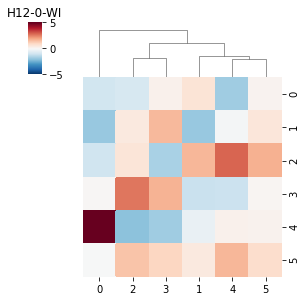

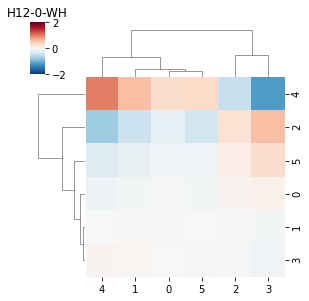

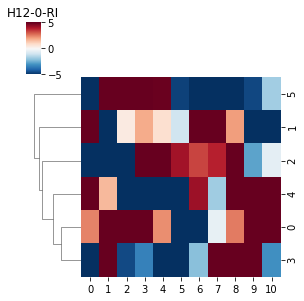

In [ ]:
import time
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

for HIDDEN_SIZE in [12]:
    print("Setting: " + colors.fail + "HIDDEN SIZE={}".format(HIDDEN_SIZE) + colors.close)
    for iter in range(1):
        #model = BuildModel_Reduction()
        model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=150,
                  validation_data=(x_val, y_val),
                  callbacks=[EearlyStopLoss(threshold=0.01)],
                  verbose=1)
        wi, wh, wb, ri, ro = GetParams()
        for NameWeight in ["WI", "WH", "RI"]:
            figsize = (10, 5 + HIDDEN_SIZE/5)
            if NameWeight == "WI": g = sns.clustermap(wi, cmap="RdBu_r", vmin=-5, vmax=5, figsize=(4,4), row_cluster=False)
            if NameWeight == "WH": g = sns.clustermap(wh, cmap="RdBu_r", vmin=-2, vmax=2, figsize=(4,4))
            if NameWeight == "RI": g = sns.clustermap(ri, cmap="RdBu_r", vmin=-5, vmax=5, figsize=(4,4), col_cluster=False)
            plt.title("H{}-{}-{}".format(HIDDEN_SIZE, iter, NameWeight))
            fname = "H{}-{}-{}.png".format(HIDDEN_SIZE, iter, NameWeight)
            #g.savefig(fname)
            #files.download(fname)
        break
    break

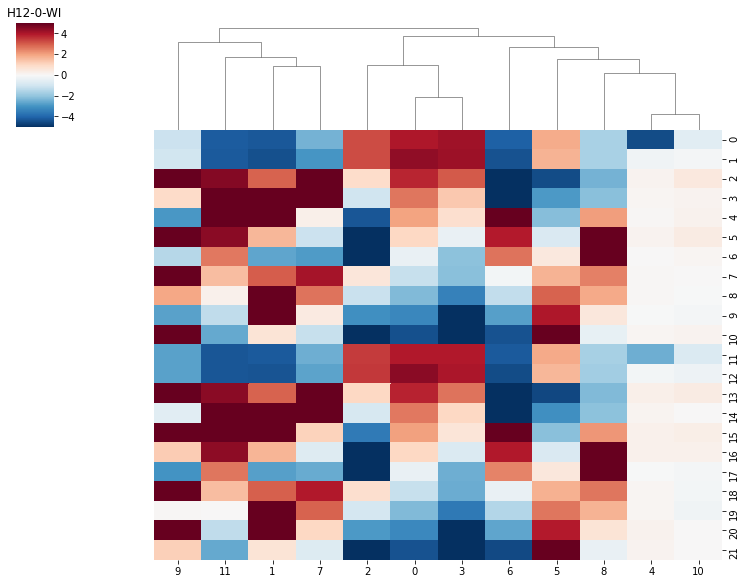

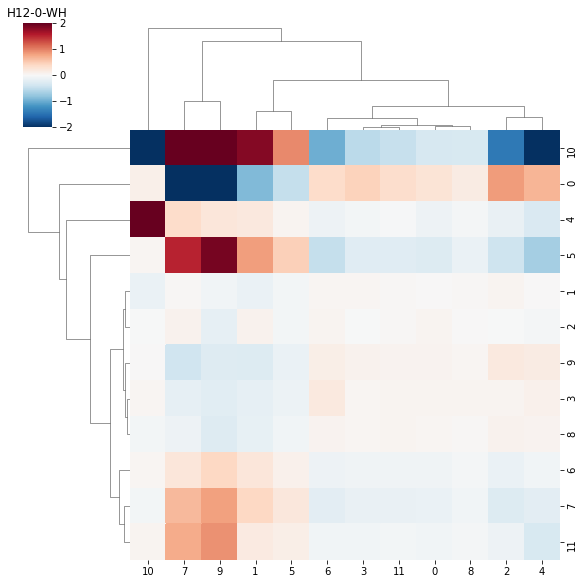

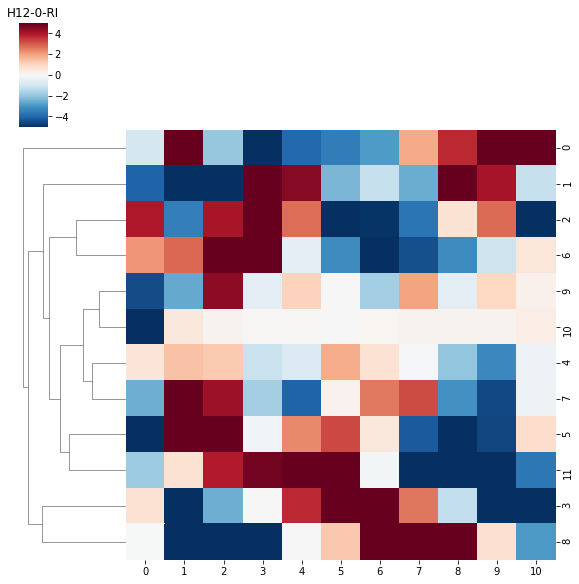

In [ ]:
wi, wh, wb, ri, ro = GetParams()
for NameWeight in ["WI", "WH", "RI"]:
    figsize = (10, 5 + HIDDEN_SIZE/5)
    if NameWeight == "WI": g = sns.clustermap(wi, cmap="RdBu_r", vmin=-5, vmax=5, figsize=(8+HIDDEN_SIZE/5, 8), row_cluster=False)
    if NameWeight == "WH": g = sns.clustermap(wh, cmap="RdBu_r", vmin=-2, vmax=2, figsize=(6+HIDDEN_SIZE/6, 6+HIDDEN_SIZE/6))
    if NameWeight == "RI": g = sns.clustermap(ri, cmap="RdBu_r", vmin=-5, vmax=5, figsize=(6+HIDDEN_SIZE/6, 6+HIDDEN_SIZE/6), col_cluster=False)
    plt.title("H{}-{}-{}".format(HIDDEN_SIZE, iter, NameWeight))
    fname = "H{}-{}-{}.png".format(HIDDEN_SIZE, iter, NameWeight)
    #g.savefig(fname)
    #files.download(fname)

single correlation


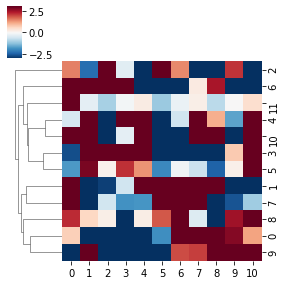

single euclidean


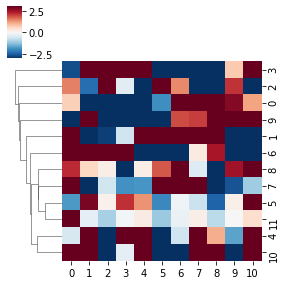

single sqeuclidean


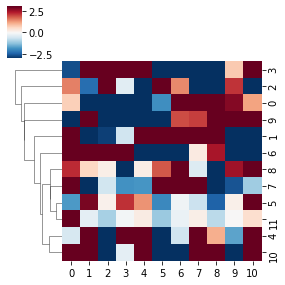

single cosine


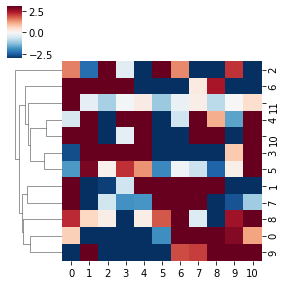

single hamming


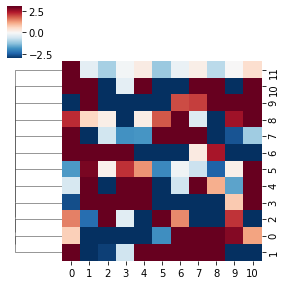

single chebyshev


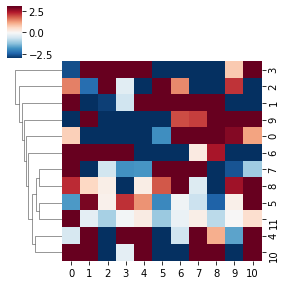

single jaccard


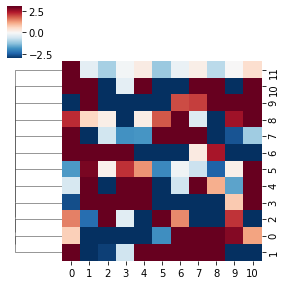

single canberra


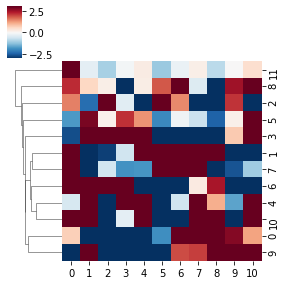

complete correlation


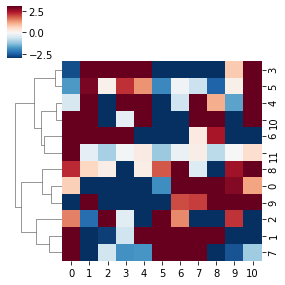

complete euclidean


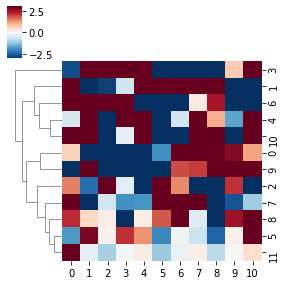

complete sqeuclidean


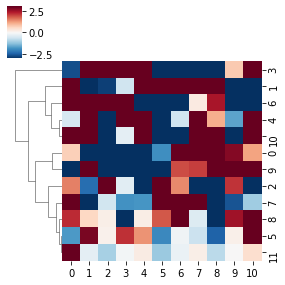

complete cosine


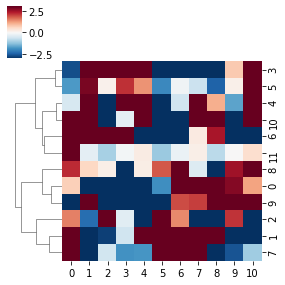

complete hamming


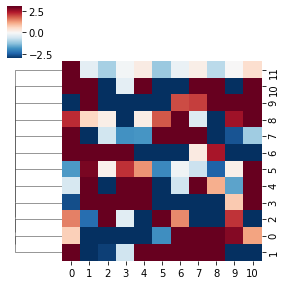

complete chebyshev


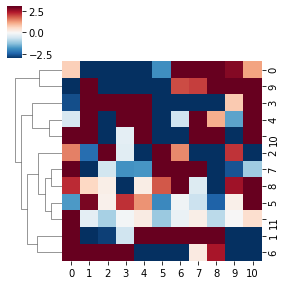

complete jaccard


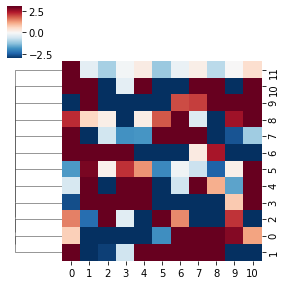

complete canberra


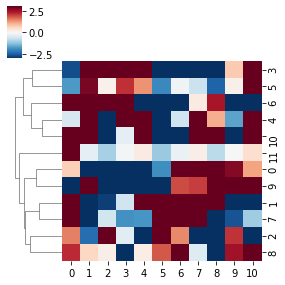

weighted correlation


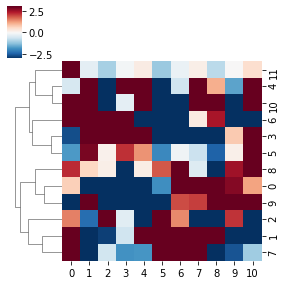

weighted euclidean


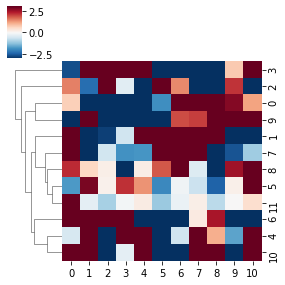

weighted sqeuclidean


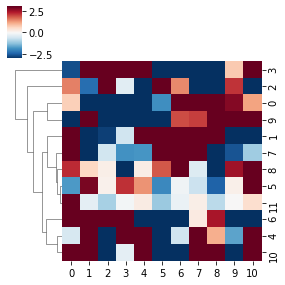

weighted cosine


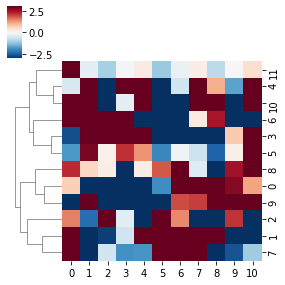

weighted hamming


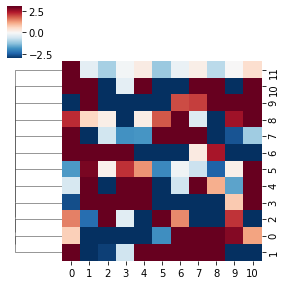

weighted chebyshev


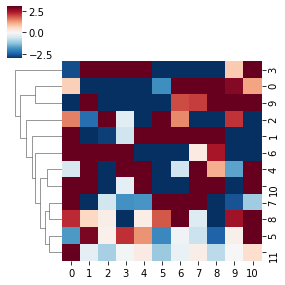

weighted jaccard


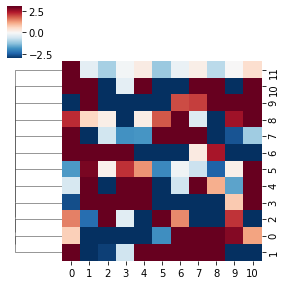

weighted canberra


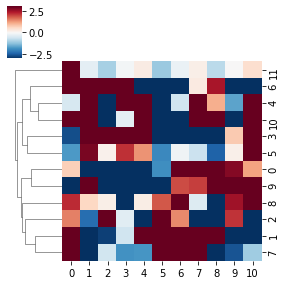

In [ ]:
M = ["single", "complete", "weighted"]
D = ["correlation", "euclidean", "sqeuclidean", "cosine", "hamming", "chebyshev", "jaccard", "canberra", ]
for method in M:
    for distance in D:
        print(method, distance)
        g = sns.clustermap(ri, cmap="RdBu_r", 
                        vmin=-3, vmax=3, 
                        figsize=(4,4), 
                        col_cluster=False, 
                        method = method, metric=distance,
                        )
        plt.show()